# Create drive time maps
References:
* Mapbox: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scattermapbox.html
* Slider: https://community.plotly.com/t/multiple-traces-with-a-single-slider-in-plotly/16356

In [1]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
import json
import config

In [2]:
CWD = Path.cwd()
API_KEY = config.API_KEY

with open(CWD / 'data/data_4.json', 'r') as f:
    data_2 = json.load(f)

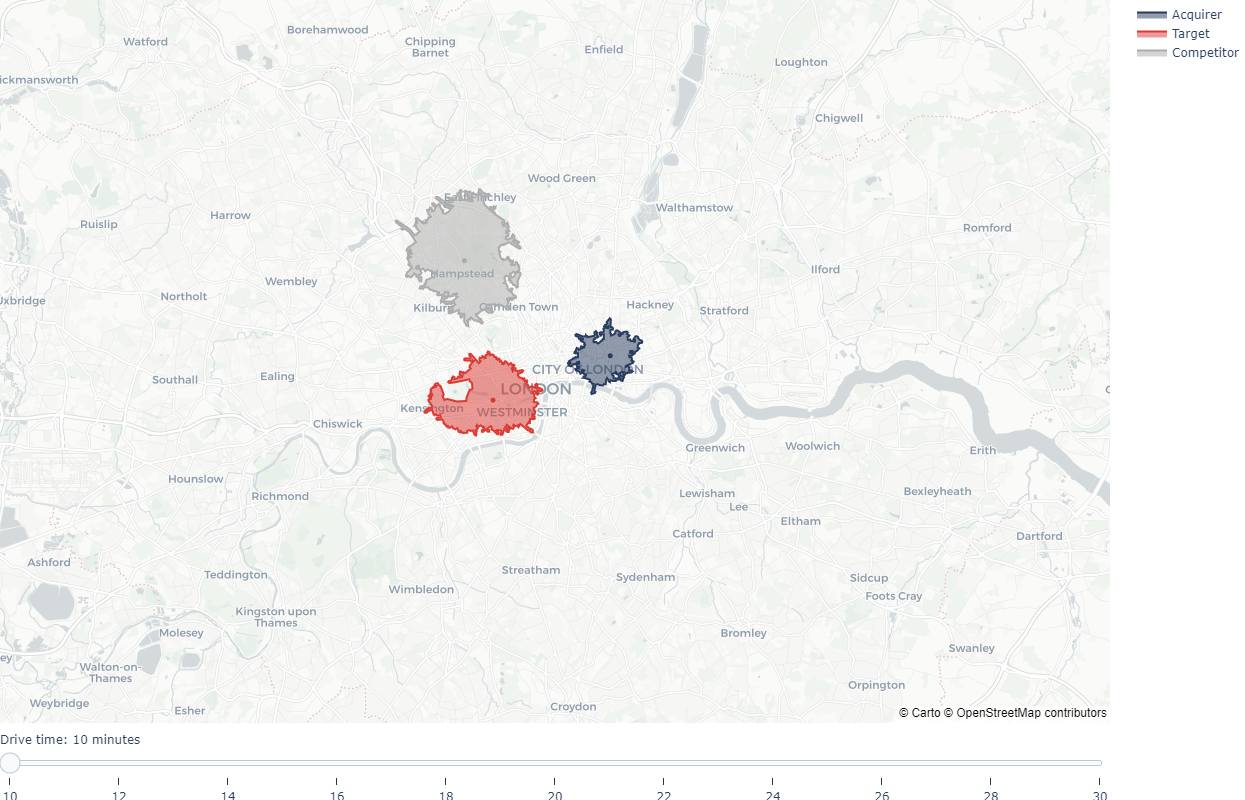

In [3]:
parties = {
    'acq': {
        'name': 'Acquirer',
        'trace_list': [],
        'color': "rgb(39, 59, 94)",
        'polygon': data_2[0],
        'lon': [-0.0765217816918618],
        'lat': [51.5214256994163],
    },
    'tgt': {
        'name': 'Target',
        'trace_list': [],
        'color': "rgb(220, 56, 50)",
        'polygon': data_2[1],
        'lon': [-0.1569644800202259], 
        'lat': [51.50248527968124],
    },
    'cmp': {
        'name': 'Competitor',
        'trace_list': [],
        'color': "rgb(172, 172, 172)",
        'polygon': data_2[2],
        'lon': [-0.17665332261961805], 
        'lat': [51.562074514060185],
    },
}


distances = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
num_steps = len(distances)

for distance in distances:
    
    for party in ['acq', 'tgt', 'cmp']:
        polygon = parties[party]['polygon'][f'driving_{distance}']['features'][0]['geometry']['coordinates'][0]
        lon_list = []
        lat_list = []
        for lon, lat in polygon:
            lon_list.append(lon)
            lat_list.append(lat)

        f = go.Scattermapbox(
            lat = lat_list,
            lon = lon_list,
            fill='toself',
            mode='lines',
            name=f"{parties[party]['name']}",
            hoverinfo='none',
            marker = dict(
                color = parties[party]['color']
            ),
            visible=False
        )
        
        parties[party]['trace_list'].append(f)
        
        
# Add centroid markers:
trace_list_centr = []
for party in ['acq', 'tgt', 'cmp']:
    trace_list_centr.append(
        go.Scattermapbox(
            lon = parties[party]['lon'], 
            lat = parties[party]['lat'],
            fill='toself',
            mode='markers',
            hoverinfo='none',
            showlegend=False,
            marker = dict(
                color = parties[party]['color']
            ),
        )
    )


fig = go.Figure(data=parties['acq']['trace_list']+parties['tgt']['trace_list']+parties['cmp']['trace_list']+trace_list_centr)


fig.data[0].visible = True
fig.data[num_steps].visible = True
fig.data[num_steps*2].visible = True
fig.data[-1].visible = True
fig.data[-2].visible = True
fig.data[-3].visible = True

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox = {
                'center': { 'lon': -0.114419, 'lat': 51.518998},
                'zoom': 10, 
                'layers': []
            },
    margin = {'l':0, 'r':0, 'b':0, 't':0},
    mapbox_accesstoken=API_KEY,
    width=1000,
    height=800,
 )


steps = []
for i in range(num_steps):
    # Hide all traces
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(fig.data)],
        label=str(10 + (i * 2))
    )
    # Enable the traces we want to see
    step['args'][1][i] = True
    step['args'][1][i+num_steps] = True
    step['args'][1][i+(num_steps*2)] = True
    
    # Add dots for centroids which we want to see always
    step['args'][1][-1] = True 
    step['args'][1][-2] = True
    step['args'][1][-3] = True
    
    # Add step to step list
    steps.append(step)

sliders = [dict(
    steps = steps,
    currentvalue={"prefix": "Drive time: ", "suffix": " minutes"},
    pad={"t": 5},
)]

fig.layout.sliders = sliders


fig.show()

In [4]:
fig.write_html(CWD / "timeline_three_party.html")